# Live Odds Monitor - Betting Strategy Analysis

**Comprehensive analysis of fade betting strategy performance**

This notebook analyzes historical betting data from both backfill simulations and live monitoring. It generates visualizations to understand:
- Win rates by sport (NBA vs NCAAB)
- ROI optimization by line movement threshold
- Time remaining effectiveness (sport-adjusted)
- Opening spread size impact
- Quality score distribution

Last updated: January 20, 2026

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Database location
DB_PATH = Path.home() / ".local" / "share" / "live-odds-monitor" / "odds_monitor.db"

print(f"Database: {DB_PATH}")
print(f"Database exists: {DB_PATH.exists()}")

Database: /Users/jordanalexander/.local/share/live-odds-monitor/odds_monitor.db
Database exists: True


In [2]:
def load_all_bets():
    """Load bets from both simulated_bets (backfill) and bet_outcomes (live)."""
    conn = sqlite3.connect(DB_PATH)
    
    # Load historical backfill data
    df_backfill = pd.read_sql_query("""
        SELECT 
            game_id,
            sport,
            strategy,
            bet_team,
            bet_spread,
            opening_spread,
            pct_change * 100 as spread_change_pct,
            mins_remaining,
            final_margin,
            covered,
            profit
        FROM simulated_bets
        WHERE covered IS NOT NULL
    """, conn)
    
    # Load live monitor data
    df_live = pd.read_sql_query("""
        SELECT 
            b.game_id,
            COALESCE(g.sport, 'unknown') as sport,
            b.bet_type as strategy,
            b.bet_team,
            b.bet_spread,
            b.opening_spread,
            COALESCE(b.pct_change, 0) * 100 as spread_change_pct,
            b.mins_remaining,
            b.final_margin,
            b.covered,
            b.profit
        FROM bet_outcomes b
        LEFT JOIN games g ON b.game_id = g.id
        WHERE b.covered IS NOT NULL
    """, conn)
    
    conn.close()
    
    # Combine and add metadata
    df = pd.concat([df_backfill, df_live], ignore_index=True)
    df['win'] = df['covered'].astype(bool)
    df['sport_name'] = df['sport'].apply(lambda x: 'NBA' if 'nba' in x.lower() else 'NCAAB')
    
    return df

# Load data
df = load_all_bets()

print(f"Total bets: {len(df)}")
print(f"  - Backfill: {len(df[df['mins_remaining'].isna()])}")
print(f"  - Live: {len(df[df['mins_remaining'].notna()])}")
print(f"\nWin Rate: {df['win'].mean() * 100:.1f}%")
print(f"Total Profit: ${df['profit'].sum():.2f}")
print(f"\nBy Sport:")
print(df.groupby('sport_name').agg({
    'win': ['count', 'sum', 'mean'],
    'profit': 'sum'
}).round(3))

Total bets: 121
  - Backfill: 120
  - Live: 1

Win Rate: 77.7%
Total Profit: $6430.00

By Sport:
             win             profit
           count sum   mean     sum
sport_name                         
NBA           62  55  0.887  4730.0
NCAAB         59  39  0.661  1700.0


/var/folders/nw/lzld_czj7f7_vn7bdmb_7wbr0000gn/T/ipykernel_76592/1987240192.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df_backfill, df_live], ignore_index=True)


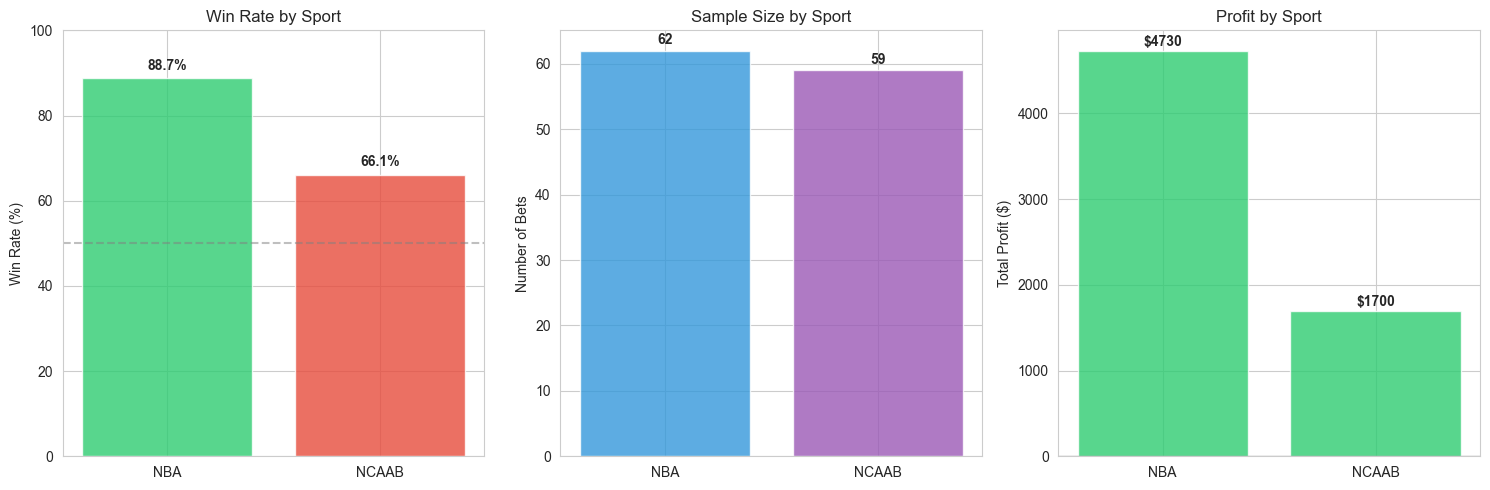


📊 Sport Performance Summary:
            total  wins  win_rate  profit
sport_name                               
NBA            62    55  0.887097  4730.0
NCAAB          59    39  0.661017  1700.0


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Win Rate by Sport
sport_stats = df.groupby('sport_name').agg({
    'win': ['count', 'sum', 'mean'],
    'profit': 'sum'
})
sport_stats.columns = ['total', 'wins', 'win_rate', 'profit']

colors = ['#2ecc71' if w >= 0.75 else '#e74c3c' for w in sport_stats['win_rate']]
axes[0].bar(sport_stats.index, sport_stats['win_rate'] * 100, color=colors, alpha=0.8)
axes[0].axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Break-even')
axes[0].set_ylabel('Win Rate (%)')
axes[0].set_title('Win Rate by Sport')
axes[0].set_ylim(0, 100)
for i, (idx, row) in enumerate(sport_stats.iterrows()):
    axes[0].text(i, row['win_rate'] * 100 + 2, f"{row['win_rate']*100:.1f}%", ha='center', fontweight='bold')

# Total Bets by Sport
axes[1].bar(sport_stats.index, sport_stats['total'], color=['#3498db', '#9b59b6'], alpha=0.8)
axes[1].set_ylabel('Number of Bets')
axes[1].set_title('Sample Size by Sport')
for i, (idx, row) in enumerate(sport_stats.iterrows()):
    axes[1].text(i, row['total'] + 1, f"{int(row['total'])}", ha='center', fontweight='bold')

# Profit by Sport
profit_colors = ['#2ecc71' if p > 0 else '#e74c3c' for p in sport_stats['profit']]
axes[2].bar(sport_stats.index, sport_stats['profit'], color=profit_colors, alpha=0.8)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[2].set_ylabel('Total Profit ($)')
axes[2].set_title('Profit by Sport')
for i, (idx, row) in enumerate(sport_stats.iterrows()):
    axes[2].text(i, row['profit'] + (50 if row['profit'] > 0 else -100), f"${row['profit']:.0f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('figures/sport_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Sport Performance Summary:")
print(sport_stats.to_string())

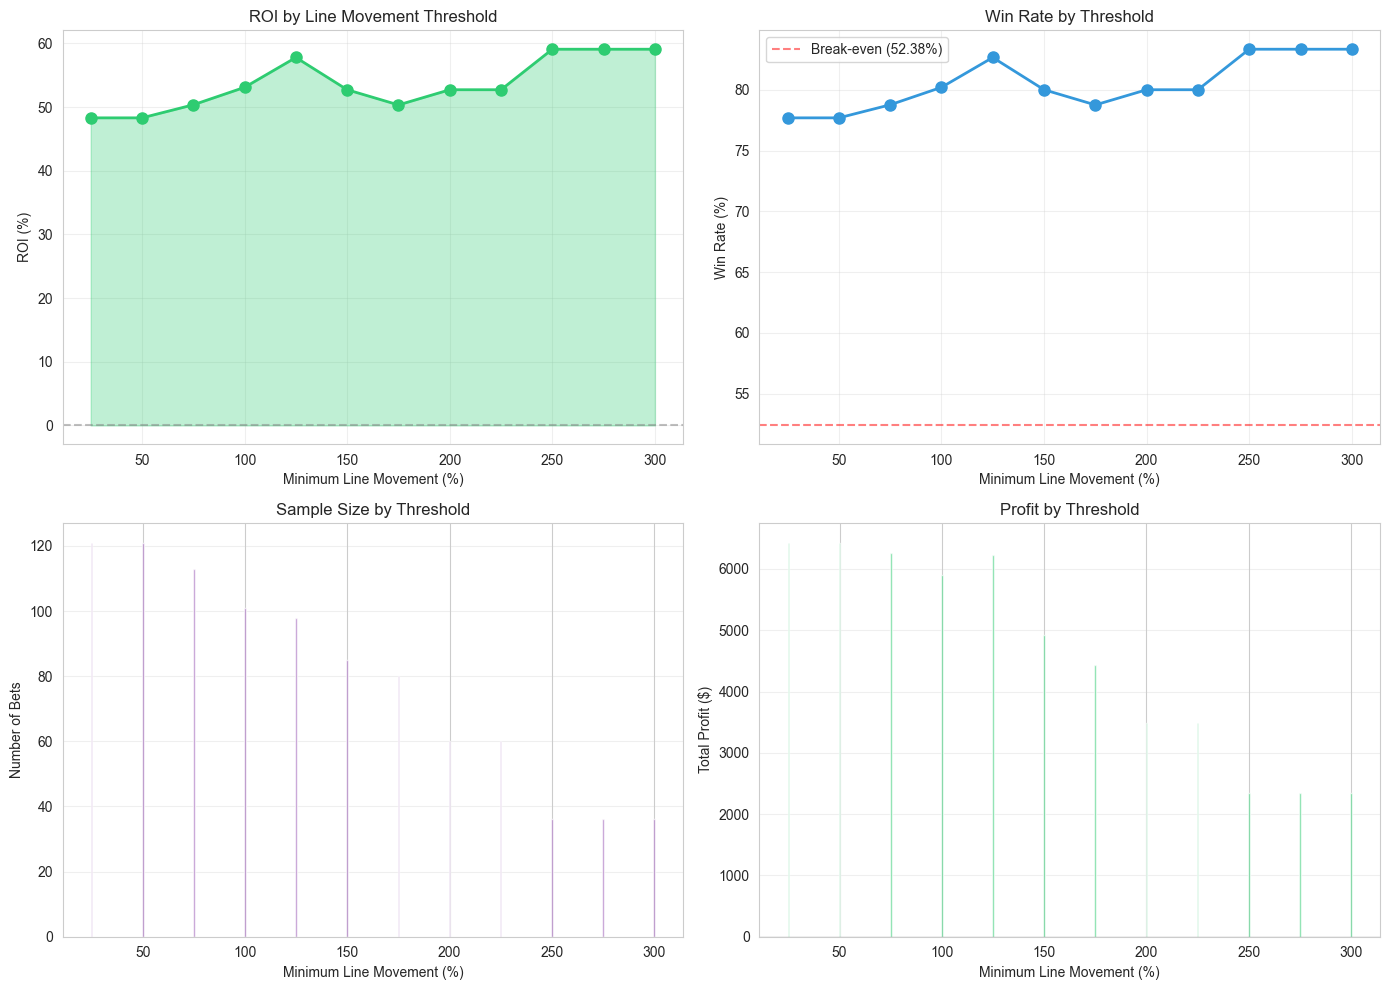


🎯 Best Threshold: 250%
   ROI: 59.1%
   Win Rate: 83.3%
   Sample Size: 36 bets


In [4]:
# Test different thresholds
thresholds = list(range(25, 325, 25))
threshold_results = []

for threshold in thresholds:
    matching = df[df['spread_change_pct'] >= threshold]
    if len(matching) > 0:
        wins = matching['win'].sum()
        total = len(matching)
        profit = matching['profit'].sum()
        roi = (profit / (total * 110)) * 100 if total > 0 else 0
        
        threshold_results.append({
            'threshold': threshold,
            'bets': total,
            'wins': wins,
            'win_rate': wins / total,
            'profit': profit,
            'roi': roi
        })

df_thresh = pd.DataFrame(threshold_results)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ROI vs Threshold
axes[0, 0].plot(df_thresh['threshold'], df_thresh['roi'], 'o-', linewidth=2, markersize=8, color='#2ecc71')
axes[0, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].fill_between(df_thresh['threshold'], 0, df_thresh['roi'], alpha=0.3, color='#2ecc71')
axes[0, 0].set_xlabel('Minimum Line Movement (%)')
axes[0, 0].set_ylabel('ROI (%)')
axes[0, 0].set_title('ROI by Line Movement Threshold')
axes[0, 0].grid(True, alpha=0.3)

# Win Rate vs Threshold
axes[0, 1].plot(df_thresh['threshold'], df_thresh['win_rate'] * 100, 'o-', linewidth=2, markersize=8, color='#3498db')
axes[0, 1].axhline(y=52.38, color='red', linestyle='--', alpha=0.5, label='Break-even (52.38%)')
axes[0, 1].set_xlabel('Minimum Line Movement (%)')
axes[0, 1].set_ylabel('Win Rate (%)')
axes[0, 1].set_title('Win Rate by Threshold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Sample Size vs Threshold
axes[1, 0].bar(df_thresh['threshold'], df_thresh['bets'], color='#9b59b6', alpha=0.7)
axes[1, 0].set_xlabel('Minimum Line Movement (%)')
axes[1, 0].set_ylabel('Number of Bets')
axes[1, 0].set_title('Sample Size by Threshold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Profit vs Threshold
colors = ['#2ecc71' if p > 0 else '#e74c3c' for p in df_thresh['profit']]
axes[1, 1].bar(df_thresh['threshold'], df_thresh['profit'], color=colors, alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].set_xlabel('Minimum Line Movement (%)')
axes[1, 1].set_ylabel('Total Profit ($)')
axes[1, 1].set_title('Profit by Threshold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Find best threshold
best = df_thresh.loc[df_thresh['roi'].idxmax()]
print(f"\n🎯 Best Threshold: {best['threshold']:.0f}%")
print(f"   ROI: {best['roi']:.1f}%")
print(f"   Win Rate: {best['win_rate']*100:.1f}%")
print(f"   Sample Size: {best['bets']:.0f} bets")

/var/folders/nw/lzld_czj7f7_vn7bdmb_7wbr0000gn/T/ipykernel_76592/1047765772.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spread_stats = df.groupby('spread_category').agg({


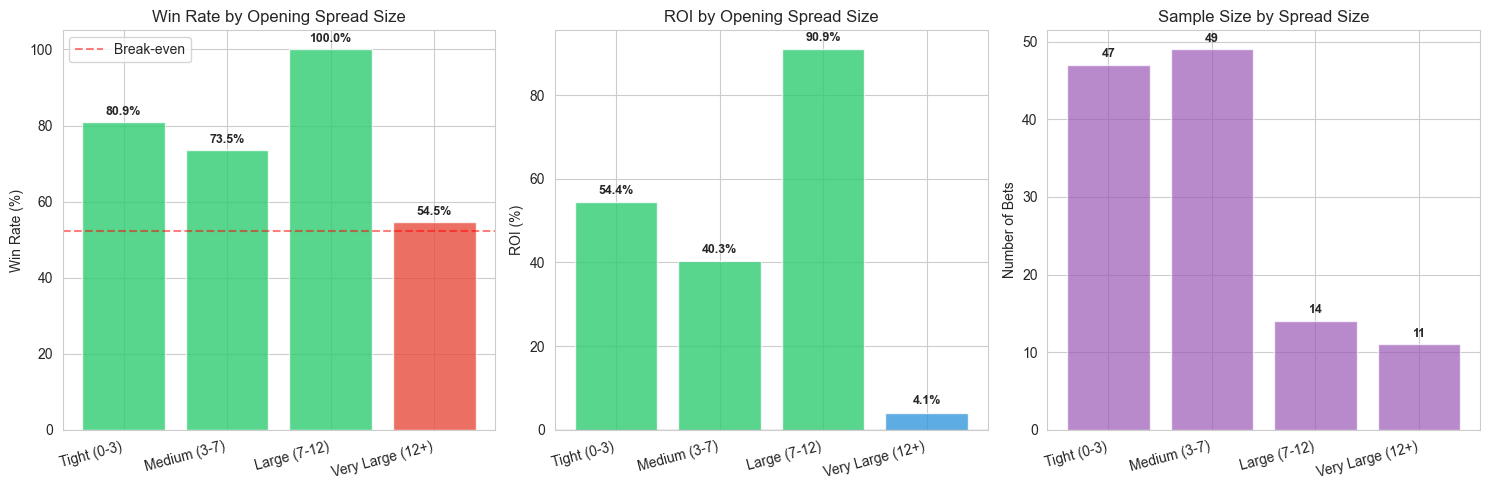


📊 Spread Size Analysis:
                  total  wins  win_rate  profit    roi
spread_category                                       
Tight (0-3)          47    38      0.81  2810.0  54.35
Medium (3-7)         49    36      0.73  2170.0  40.26
Large (7-12)         14    14      1.00  1400.0  90.91
Very Large (12+)     11     6      0.55    50.0   4.13


In [5]:
# Categorize by opening spread size
df['spread_category'] = pd.cut(
    df['opening_spread'].abs(),
    bins=[0, 3, 7, 12, 100],
    labels=['Tight (0-3)', 'Medium (3-7)', 'Large (7-12)', 'Very Large (12+)']
)

spread_stats = df.groupby('spread_category').agg({
    'win': ['count', 'sum', 'mean'],
    'profit': 'sum'
})
spread_stats.columns = ['total', 'wins', 'win_rate', 'profit']
spread_stats['roi'] = (spread_stats['profit'] / (spread_stats['total'] * 110)) * 100

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Win Rate by Spread Size
colors = ['#2ecc71' if w >= 0.7 else '#e67e22' if w >= 0.6 else '#e74c3c' for w in spread_stats['win_rate']]
axes[0].bar(range(len(spread_stats)), spread_stats['win_rate'] * 100, color=colors, alpha=0.8)
axes[0].set_xticks(range(len(spread_stats)))
axes[0].set_xticklabels(spread_stats.index, rotation=15, ha='right')
axes[0].axhline(y=52.38, color='red', linestyle='--', alpha=0.5, label='Break-even')
axes[0].set_ylabel('Win Rate (%)')
axes[0].set_title('Win Rate by Opening Spread Size')
axes[0].legend()
for i, (idx, row) in enumerate(spread_stats.iterrows()):
    axes[0].text(i, row['win_rate'] * 100 + 2, f"{row['win_rate']*100:.1f}%", ha='center', fontsize=9, fontweight='bold')

# ROI by Spread Size
roi_colors = ['#2ecc71' if r > 40 else '#3498db' if r > 0 else '#e74c3c' for r in spread_stats['roi']]
axes[1].bar(range(len(spread_stats)), spread_stats['roi'], color=roi_colors, alpha=0.8)
axes[1].set_xticks(range(len(spread_stats)))
axes[1].set_xticklabels(spread_stats.index, rotation=15, ha='right')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_ylabel('ROI (%)')
axes[1].set_title('ROI by Opening Spread Size')
for i, (idx, row) in enumerate(spread_stats.iterrows()):
    axes[1].text(i, row['roi'] + (2 if row['roi'] > 0 else -5), f"{row['roi']:.1f}%", ha='center', fontsize=9, fontweight='bold')

# Sample Size
axes[2].bar(range(len(spread_stats)), spread_stats['total'], color='#9b59b6', alpha=0.7)
axes[2].set_xticks(range(len(spread_stats)))
axes[2].set_xticklabels(spread_stats.index, rotation=15, ha='right')
axes[2].set_ylabel('Number of Bets')
axes[2].set_title('Sample Size by Spread Size')
for i, (idx, row) in enumerate(spread_stats.iterrows()):
    axes[2].text(i, row['total'] + 1, f"{int(row['total'])}", ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/spread_size_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Spread Size Analysis:")
print(spread_stats.round(2))

/var/folders/nw/lzld_czj7f7_vn7bdmb_7wbr0000gn/T/ipykernel_76592/904075794.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data_to_plot, labels=['Wins', 'Losses'], patch_artist=True,


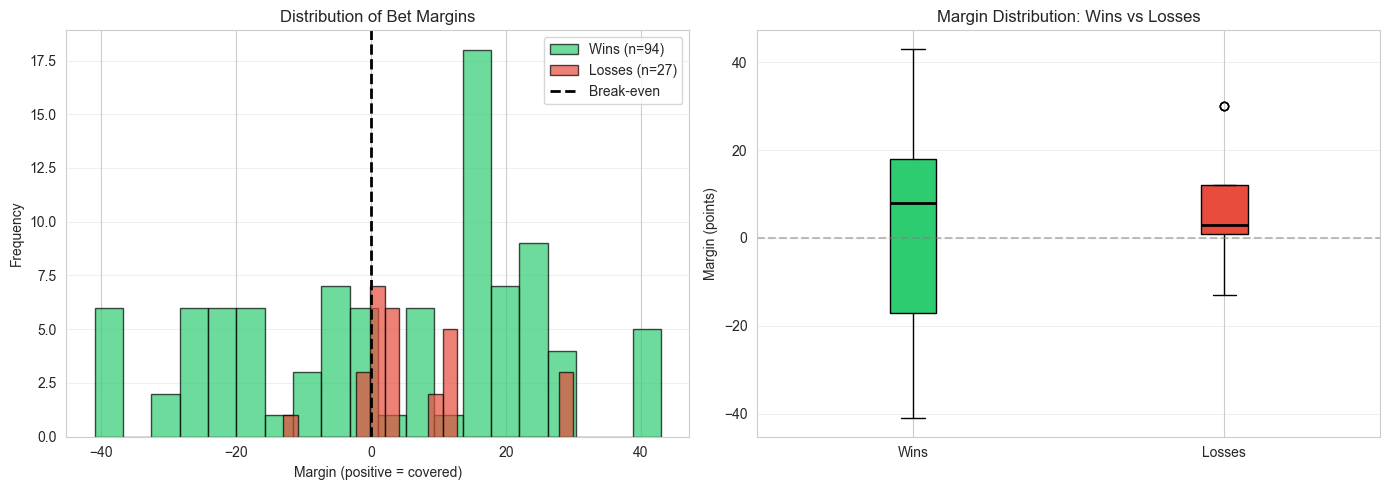


📊 Margin Analysis:
Wins - Mean: 2.22, Median: 8.00, Std: 22.27
Losses - Mean: 6.48, Median: 3.00, Std: 10.17

Close losses (<3 pts): 10 (37.0%)


In [6]:
wins = df[df['win'] == True]['final_margin']
losses = df[df['win'] == False]['final_margin']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of margins
axes[0].hist(wins, bins=20, alpha=0.7, color='#2ecc71', label=f'Wins (n={len(wins)})', edgecolor='black')
axes[0].hist(losses, bins=20, alpha=0.7, color='#e74c3c', label=f'Losses (n={len(losses)})', edgecolor='black')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=2, label='Break-even')
axes[0].set_xlabel('Margin (positive = covered)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Bet Margins')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Box plot comparison
data_to_plot = [wins.dropna(), losses.dropna()]
bp = axes[1].boxplot(data_to_plot, labels=['Wins', 'Losses'], patch_artist=True, 
                      medianprops=dict(color='black', linewidth=2))
bp['boxes'][0].set_facecolor('#2ecc71')
bp['boxes'][1].set_facecolor('#e74c3c')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Margin (points)')
axes[1].set_title('Margin Distribution: Wins vs Losses')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/margin_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Margin Analysis:")
print(f"Wins - Mean: {wins.mean():.2f}, Median: {wins.median():.2f}, Std: {wins.std():.2f}")
print(f"Losses - Mean: {losses.mean():.2f}, Median: {losses.median():.2f}, Std: {losses.std():.2f}")
print(f"\nClose losses (<3 pts): {len(losses[losses.abs() < 3])} ({len(losses[losses.abs() < 3])/len(losses)*100:.1f}%)")

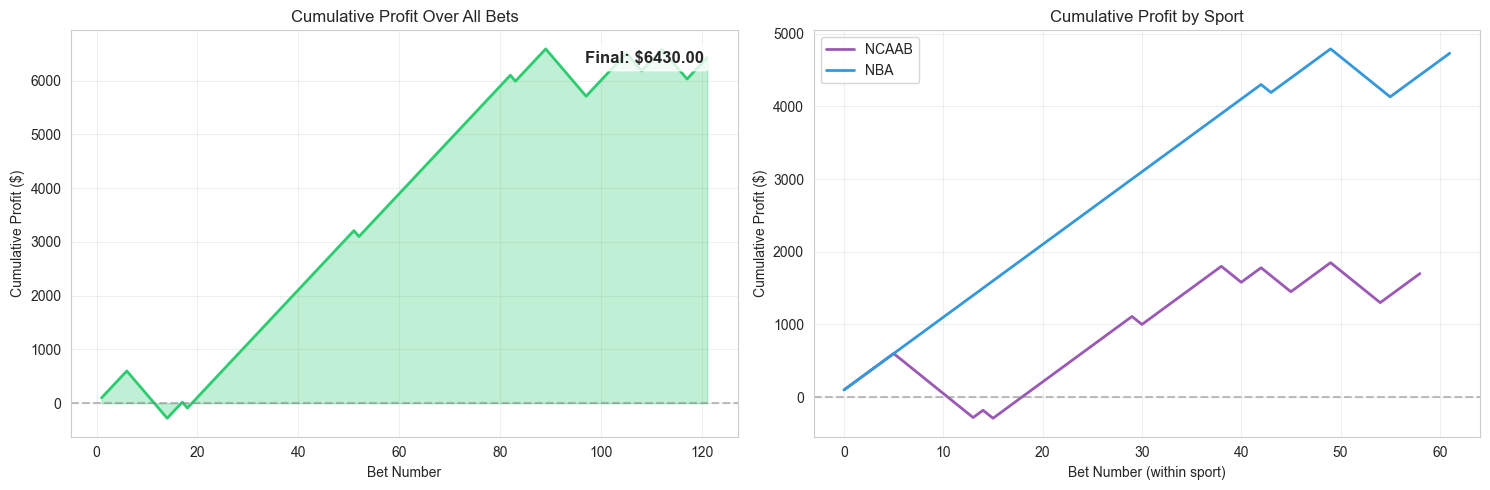

In [7]:
# Calculate cumulative profit
df_sorted = df.sort_values('game_id').reset_index(drop=True)
df_sorted['cumulative_profit'] = df_sorted['profit'].cumsum()
df_sorted['bet_number'] = range(1, len(df_sorted) + 1)

# Overall and by sport
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall cumulative profit
axes[0].plot(df_sorted['bet_number'], df_sorted['cumulative_profit'], linewidth=2, color='#2ecc71')
axes[0].fill_between(df_sorted['bet_number'], 0, df_sorted['cumulative_profit'], alpha=0.3, color='#2ecc71')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Bet Number')
axes[0].set_ylabel('Cumulative Profit ($)')
axes[0].set_title('Cumulative Profit Over All Bets')
axes[0].grid(True, alpha=0.3)
axes[0].text(0.95, 0.95, f'Final: ${df_sorted["cumulative_profit"].iloc[-1]:.2f}', 
             transform=axes[0].transAxes, ha='right', va='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=12, fontweight='bold')

# By sport
for sport in df_sorted['sport_name'].unique():
    sport_df = df_sorted[df_sorted['sport_name'] == sport].copy()
    sport_df['cumulative_profit_sport'] = sport_df['profit'].cumsum()
    color = '#3498db' if sport == 'NBA' else '#9b59b6'
    axes[1].plot(range(len(sport_df)), sport_df['cumulative_profit_sport'], 
                 linewidth=2, label=sport, color=color)

axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Bet Number (within sport)')
axes[1].set_ylabel('Cumulative Profit ($)')
axes[1].set_title('Cumulative Profit by Sport')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/cumulative_profit.png', dpi=300, bbox_inches='tight')
plt.show()

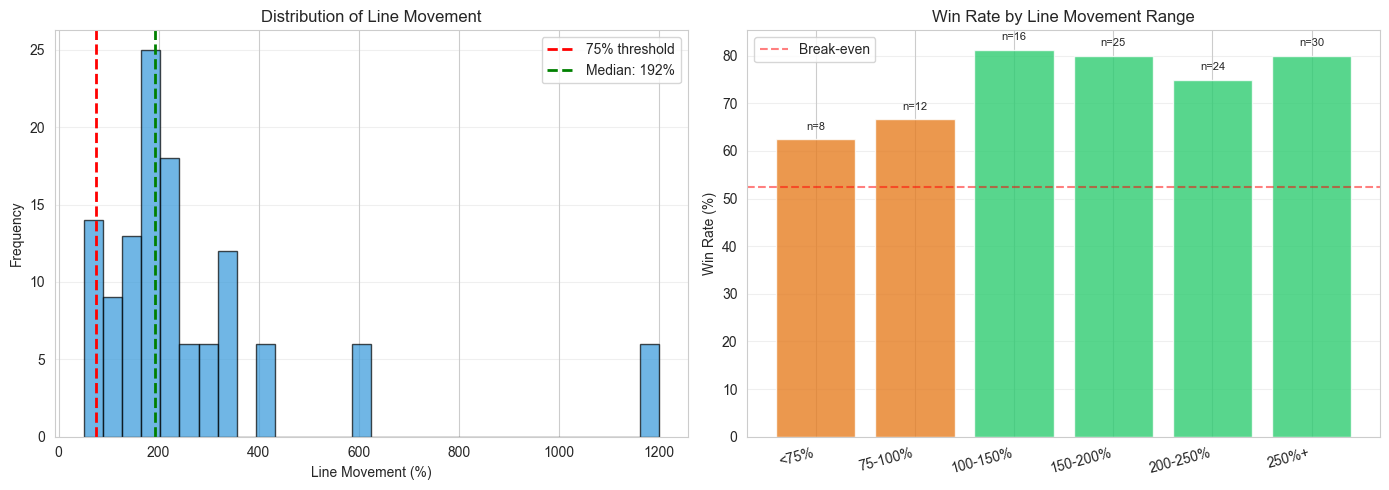


📊 Line Movement Analysis:
              count  win_rate
movement_bin                 
<75%              8  0.625000
75-100%          12  0.666667
100-150%         16  0.812500
150-200%         25  0.800000
200-250%         24  0.750000
250%+            30  0.800000


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of line movement
axes[0].hist(df['spread_change_pct'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].axvline(x=75, color='red', linestyle='--', linewidth=2, label='75% threshold')
axes[0].axvline(x=df['spread_change_pct'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["spread_change_pct"].median():.0f}%')
axes[0].set_xlabel('Line Movement (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Line Movement')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Win rate by line movement bins
bins = [0, 75, 100, 150, 200, 250, 1000]
labels = ['<75%', '75-100%', '100-150%', '150-200%', '200-250%', '250%+']
df['movement_bin'] = pd.cut(df['spread_change_pct'], bins=bins, labels=labels)

movement_stats = df.groupby('movement_bin', observed=True).agg({
    'win': ['count', 'mean']
})
movement_stats.columns = ['count', 'win_rate']

colors = ['#e74c3c' if w < 0.6 else '#e67e22' if w < 0.75 else '#2ecc71' for w in movement_stats['win_rate']]
bars = axes[1].bar(range(len(movement_stats)), movement_stats['win_rate'] * 100, color=colors, alpha=0.8)
axes[1].set_xticks(range(len(movement_stats)))
axes[1].set_xticklabels(movement_stats.index, rotation=15, ha='right')
axes[1].axhline(y=52.38, color='red', linestyle='--', alpha=0.5, label='Break-even')
axes[1].set_ylabel('Win Rate (%)')
axes[1].set_title('Win Rate by Line Movement Range')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Add sample sizes on bars
for i, (idx, row) in enumerate(movement_stats.iterrows()):
    axes[1].text(i, row['win_rate'] * 100 + 2, f"n={int(row['count'])}", ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('figures/line_movement_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Line Movement Analysis:")
print(movement_stats)

In [9]:
print("=" * 80)
print("📊 COMPREHENSIVE STRATEGY SUMMARY")
print("=" * 80)

print(f"\n🎯 Overall Performance:")
print(f"   Total Bets: {len(df)}")
print(f"   Wins: {df['win'].sum()} | Losses: {(~df['win']).sum()}")
print(f"   Win Rate: {df['win'].mean() * 100:.1f}%")
print(f"   Total Profit: ${df['profit'].sum():.2f}")
print(f"   Average Profit/Bet: ${df['profit'].mean():.2f}")
print(f"   ROI: {(df['profit'].sum() / (len(df) * 110)) * 100:.1f}%")

print(f"\n📈 By Sport:")
for sport in ['NBA', 'NCAAB']:
    sport_df = df[df['sport_name'] == sport]
    if len(sport_df) > 0:
        win_rate = sport_df['win'].mean()
        profit = sport_df['profit'].sum()
        roi = (profit / (len(sport_df) * 110)) * 100
        print(f"   {sport:6s}: {len(sport_df):3d} bets | {win_rate*100:5.1f}% win | ${profit:7.2f} profit | {roi:5.1f}% ROI")

print(f"\n💰 Best Configurations:")
print(f"   Best Threshold: {df_thresh.loc[df_thresh['roi'].idxmax(), 'threshold']:.0f}% ({df_thresh['roi'].max():.1f}% ROI)")
print(f"   Best Spread Range: {spread_stats['roi'].idxmax()} ({spread_stats['roi'].max():.1f}% ROI)")

print(f"\n🎲 Risk Metrics:")
print(f"   Largest Win Margin: +{df['final_margin'].max():.0f} pts")
print(f"   Largest Loss Margin: {df['final_margin'].min():.0f} pts")
print(f"   Close Losses (<3 pts): {len(losses[losses.abs() < 3])} of {len(losses)} ({len(losses[losses.abs() < 3])/len(losses)*100:.1f}%)")
print(f"   Std Dev of Returns: ${df['profit'].std():.2f}")

print("=" * 80)

📊 COMPREHENSIVE STRATEGY SUMMARY

🎯 Overall Performance:
   Total Bets: 121
   Wins: 94 | Losses: 27
   Win Rate: 77.7%
   Total Profit: $6430.00
   Average Profit/Bet: $53.14
   ROI: 48.3%

📈 By Sport:
   NBA   :  62 bets |  88.7% win | $4730.00 profit |  69.4% ROI
   NCAAB :  59 bets |  66.1% win | $1700.00 profit |  26.2% ROI

💰 Best Configurations:
   Best Threshold: 250% (59.1% ROI)
   Best Spread Range: Large (7-12) (90.9% ROI)

🎲 Risk Metrics:
   Largest Win Margin: +43 pts
   Largest Loss Margin: -41 pts
   Close Losses (<3 pts): 10 of 27 (37.0%)
   Std Dev of Returns: $87.80


## 9. Summary Statistics Table

## 8. Line Movement Distribution

## 7. Cumulative Profit Over Time

## 6. Margin of Victory Distribution

## 5. Opening Spread Size Analysis

## 4. ROI by Line Movement Threshold

## 3. Performance by Sport

## 2. Load Betting Data from Database

## 1. Import Required Libraries